In [9]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [10]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [11]:
import pandas as pd

housing = load_housing_data()
housing.head()
housing.info()
housing.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [12]:
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

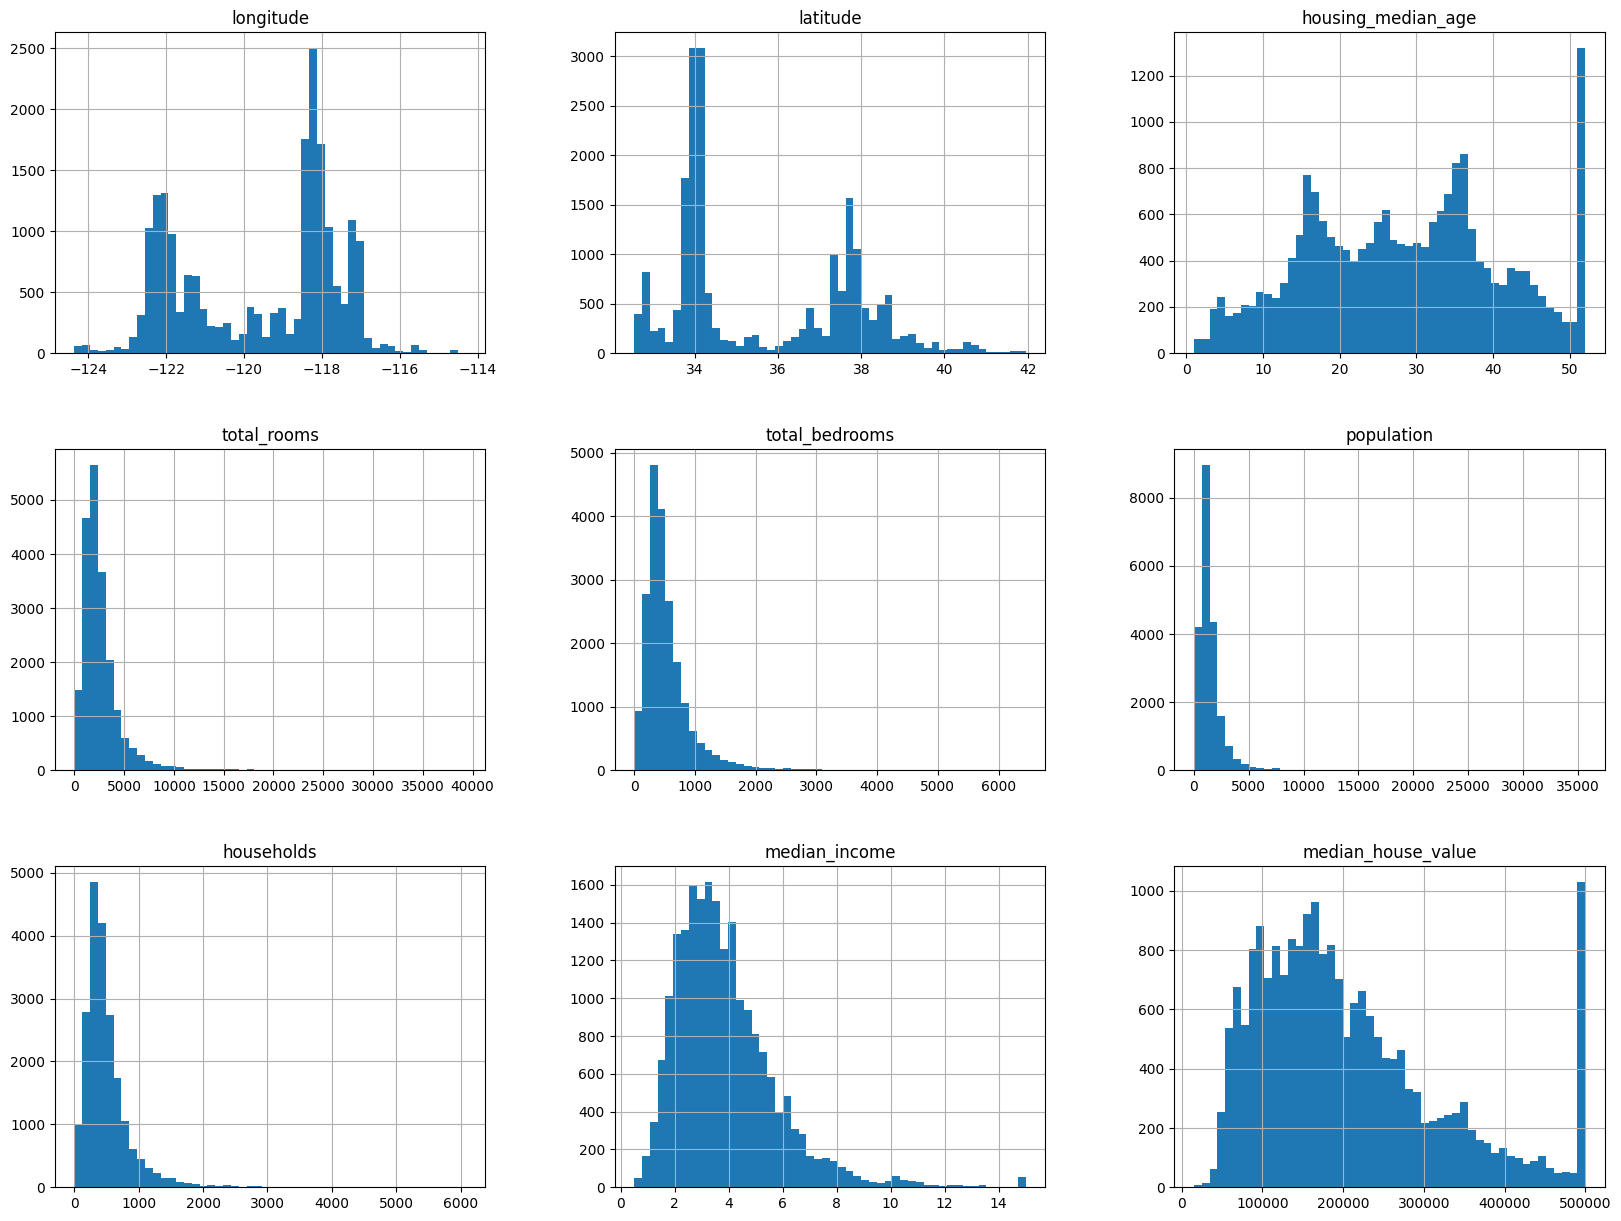

In [13]:
import matplotlib.pyplot as plt

housing.hist(bins=50, figsize=(20,15))
plt.show

In [14]:
import numpy as np
from zlib import crc32

def test_set_check(identifier, test_ratio):
    # Fix the comparison operator
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

# Reset index and create unique identifiers
housing_with_id = housing.reset_index()  
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1,2,3,4,5]
)

split = StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
    
for set_ in (strat_train_set,strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<Axes: xlabel='longitude', ylabel='latitude'>

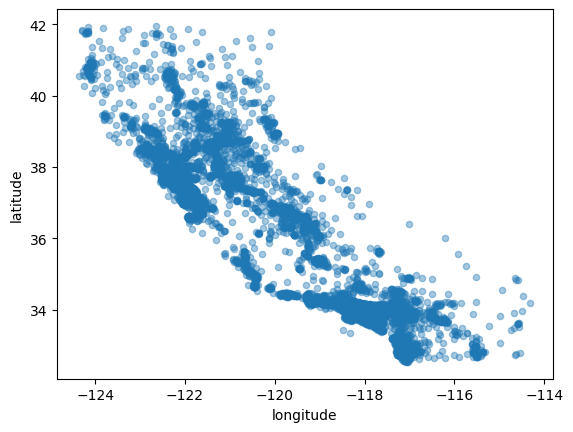

In [16]:
housing = strat_train_set.copy()

housing.plot(kind="scatter",x="longitude",y="latitude",alpha=0.4)

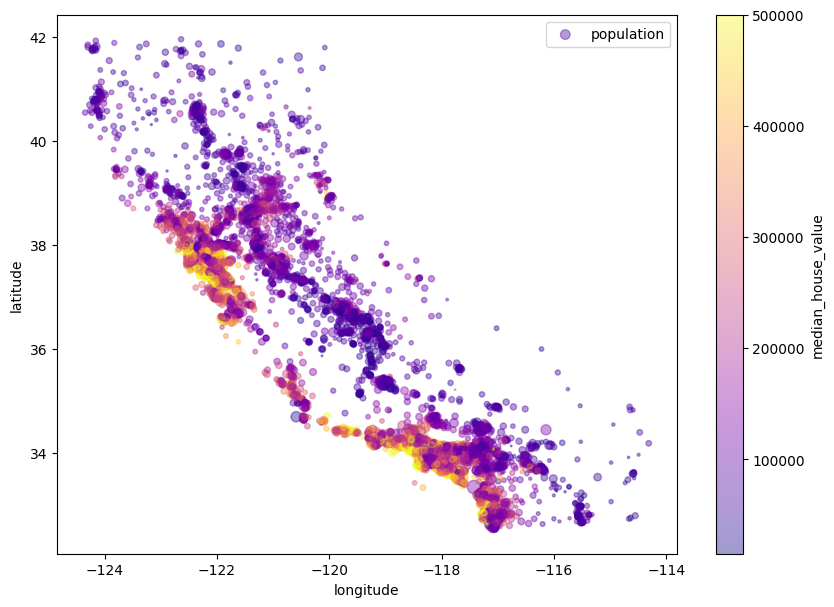

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude",alpha=0.4,
             s = np.sqrt(housing["population"]) / 2, label="population", figsize=(10,7),
             c="median_house_value",cmap=plt.get_cmap("plasma"),colorbar=True,
)
plt.legend()

<Axes: xlabel='median_income', ylabel='median_house_value'>

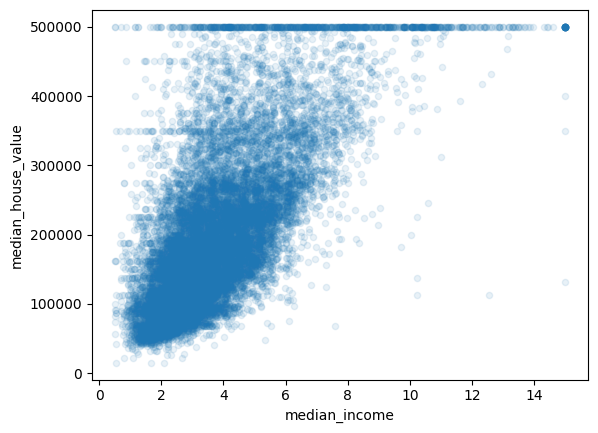

In [18]:
housing.plot(kind="scatter", x="median_income", y="median_house_value",
alpha=0.1)

In [19]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [20]:
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median,inplace=True)


/tmp/ipykernel_18940/3402938900.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  housing["total_bedrooms"].fillna(median,inplace=True)


In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
housing_num= housing.drop("ocean_proximity",axis=1)
imputer.fit(housing_num)


,missing_values,nan
,strategy,'median'
,fill_value,None
,copy,True
,add_indicator,False
,keep_empty_features,False


In [22]:
X = imputer.transform(housing_num)
housing_tr=pd.DataFrame(X,columns=housing_num.columns,index=housing_num.index)

In [23]:
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder

housing_cat = housing[["ocean_proximity"]]
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat)
housing_cat_1hot[:10]
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], shape=(16512, 5))

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
	def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
		self.add_bedrooms_per_room = add_bedrooms_per_room
	def fit(self, X, y=None):
		return self # nothing else to do
	def transform(self, X):
		rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
		population_per_household = X[:, population_ix] / X[:, households_ix]
		if self.add_bedrooms_per_room:
			bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
			return np.c_[X, rooms_per_household, population_per_household,bedrooms_per_room]
		else:
			return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

pipe1 = Pipeline([
    ("imputer",SimpleImputer(strategy="median")),
    ("attribs_adder",CombinedAttributesAdder()),
    ("std_scaller", StandardScaler())
])
housing_num_tr = pipe1.fit_transform(housing_num)

In [26]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", pipe1, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [27]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [28]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared=full_pipeline.transform(some_data)
print(f"Predictors: {lin_reg.predict(some_data_prepared)}")
print(f"Labels: {list(some_labels)}")

Predictors: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [29]:
from sklearn.metrics import mean_squared_error

housing_predictions=lin_reg.predict(housing_prepared)
lin_mse=mean_squared_error(housing_labels,housing_predictions)
lin_rmse=np.sqrt(lin_mse)
print(lin_rmse)

68627.87390018745


In [30]:
from sklearn.tree import DecisionTreeRegressor

tree_reg=DecisionTreeRegressor()
tree_reg.fit(housing_prepared,housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
print(tree_rmse)

0.0


In [31]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [32]:
def display_scores(scores):
    print("Scores", scores)
    print("Mean", scores.mean())
    print("Standart deviation:",scores.std())
    
display_scores(scores)

Scores [-5.48185708e+09 -5.13076817e+09 -4.69273687e+09 -5.07373060e+09
 -5.17265235e+09 -6.18988699e+09 -5.07742404e+09 -5.16590656e+09
 -4.70594170e+09 -4.96106471e+09]
Mean -5165196906.52075
Standart deviation: 405386088.9993599


In [33]:
lin_scores=cross_val_score(lin_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)

lin_rmse_scores=np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores [71762.76364394 64114.99166359 67771.17124356 68635.19072082
 66846.14089488 72528.03725385 73997.08050233 68802.33629334
 66443.28836884 70139.79923956]
Mean 69104.07998247063
Standart deviation: 2880.3282098180634


In [34]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared,housing_labels)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [35]:
forest_scores=cross_val_score(forest_reg,housing_prepared,housing_labels,scoring="neg_mean_squared_error",cv=10)

forest_rmse_scores=np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores [51510.8679822  49094.01212042 46530.52228281 51723.99993182
 47393.8096527  51946.18657587 52421.20475673 49885.15429623
 48609.16636961 53814.07868693]
Mean 50292.90026553201
Standart deviation: 2240.3568594919116


In [36]:
import joblib

joblib.dump(forest_reg, "forest_model.pkl")
joblib.dump(lin_reg, "LinearRegression_model.pkl")
joblib.dump(tree_reg, "DecisionTreeRegressor_model.pkl")

['DecisionTreeRegressor_model.pkl']

In [37]:
from sklearn.model_selection import GridSearchCV

grid_param=[
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()
grid_search=GridSearchCV(forest_reg,grid_param,cv=5,
                         scoring="neg_mean_squared_error",return_train_score=True)

grid_search.fit(housing_prepared,housing_labels)

,estimator,RandomForestRegressor()
,param_grid,"[{'max_features': [2, 4, ...], 'n_estimators': [3, 10, ...]}, {'bootstrap': [False], 'max_features': [2, 3, ...], 'n_estimators': [3, 10]}]"
,scoring,'neg_mean_squared_error'
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,True
,n_estimators,30
